In [2]:
# Import
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/home/user/workdir/main/src/'))))

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-02-05 09:34:33.009479: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 09:34:33.236268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-05 09:34:33.236344: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-05 09:34:33.237240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 09:34:33.329102: I tensorflow/core/platform/cpu_feature_g

# Training (Nitrate)

In [2]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019_3input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*4], ctrl_data[:, 17*4]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [3]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (50%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*4,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch <= 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-01-31 14:39:15.833867: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21700 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-31 14:39:15.836503: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21708 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-31 14:39:15.839000: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 21708 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-31 14:39:15.841417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21584 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-01-31 14:39:44.214943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:39:44.256359: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:39:44.271479: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:39:44.435173: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:39:47.211164: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9fdfd556e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-31 14:39:47.211210: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-31 14:39:47.211223: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-31 14:39:47.21123

3/3 [==============================] - ETA: 0s - loss: 25.8064  INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-01-29.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-01-29.70/assets


3/3 [==============================] - 49s 7s/step - loss: 25.8064 - val_loss: 29.6982 - lr: 0.0010
Epoch 2/1000
2/3 [===================>..........] - ETA: 0s - loss: 23.1550INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-02-29.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-02-29.55/assets


3/3 [==============================] - 9s 5s/step - loss: 23.0110 - val_loss: 29.5485 - lr: 0.0010
Epoch 3/1000
2/3 [===================>..........] - ETA: 0s - loss: 20.5945INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-03-29.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-03-29.40/assets


3/3 [==============================] - 10s 5s/step - loss: 20.5022 - val_loss: 29.4001 - lr: 0.0010
Epoch 4/1000
2/3 [===================>..........] - ETA: 0s - loss: 18.7108INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-04-29.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-04-29.25/assets


3/3 [==============================] - 10s 5s/step - loss: 18.5995 - val_loss: 29.2458 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - ETA: 0s - loss: 17.3598INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-05-29.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-05-29.10/assets


3/3 [==============================] - 10s 5s/step - loss: 17.3598 - val_loss: 29.0960 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - ETA: 0s - loss: 16.4980INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-06-28.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-06-28.88/assets


3/3 [==============================] - 10s 5s/step - loss: 16.4980 - val_loss: 28.8846 - lr: 0.0010
Epoch 7/1000
3/3 [==============================] - ETA: 0s - loss: 15.7937INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-07-28.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-07-28.61/assets


3/3 [==============================] - 10s 5s/step - loss: 15.7937 - val_loss: 28.6053 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - ETA: 0s - loss: 15.2871INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-08-28.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-08-28.26/assets


3/3 [==============================] - 10s 5s/step - loss: 15.2871 - val_loss: 28.2616 - lr: 0.0010
Epoch 9/1000
3/3 [==============================] - ETA: 0s - loss: 14.7926INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-09-27.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-09-27.88/assets


3/3 [==============================] - 10s 5s/step - loss: 14.7926 - val_loss: 27.8758 - lr: 0.0010
Epoch 10/1000
3/3 [==============================] - ETA: 0s - loss: 14.3633INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-10-27.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-10-27.50/assets


3/3 [==============================] - 10s 5s/step - loss: 14.3633 - val_loss: 27.4957 - lr: 0.0010
Epoch 11/1000
3/3 [==============================] - ETA: 0s - loss: 13.9808INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-11-27.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-11-27.12/assets


3/3 [==============================] - 10s 5s/step - loss: 13.9808 - val_loss: 27.1204 - lr: 0.0010
Epoch 12/1000
3/3 [==============================] - ETA: 0s - loss: 13.6619INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-12-27.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-12-27.00/assets


3/3 [==============================] - 10s 5s/step - loss: 13.6619 - val_loss: 26.9989 - lr: 0.0010
Epoch 13/1000
3/3 [==============================] - ETA: 0s - loss: 13.3327INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-13-26.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-13-26.83/assets


3/3 [==============================] - 10s 5s/step - loss: 13.3327 - val_loss: 26.8303 - lr: 0.0010
Epoch 14/1000
2/3 [===================>..........] - ETA: 0s - loss: 12.9878INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-14-26.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-14-26.73/assets


3/3 [==============================] - 10s 5s/step - loss: 13.0152 - val_loss: 26.7281 - lr: 0.0010
Epoch 15/1000
3/3 [==============================] - ETA: 0s - loss: 12.7446INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-15-26.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-15-26.57/assets


3/3 [==============================] - 10s 5s/step - loss: 12.7446 - val_loss: 26.5724 - lr: 0.0010
Epoch 16/1000
3/3 [==============================] - 0s 200ms/step - loss: 12.4429 - val_loss: 26.5785 - lr: 0.0010
Epoch 17/1000
3/3 [==============================] - ETA: 0s - loss: 12.1614INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-17-26.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-17-26.51/assets


3/3 [==============================] - 10s 5s/step - loss: 12.1614 - val_loss: 26.5150 - lr: 0.0010
Epoch 18/1000
3/3 [==============================] - ETA: 0s - loss: 11.8539INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-18-26.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-18-26.31/assets


3/3 [==============================] - 10s 5s/step - loss: 11.8539 - val_loss: 26.3096 - lr: 0.0010
Epoch 19/1000
3/3 [==============================] - ETA: 0s - loss: 11.5933INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-19-26.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-19-26.01/assets


3/3 [==============================] - 10s 5s/step - loss: 11.5933 - val_loss: 26.0081 - lr: 0.0010
Epoch 20/1000
3/3 [==============================] - ETA: 0s - loss: 11.3151INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-20-25.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-20-25.15/assets


3/3 [==============================] - 10s 5s/step - loss: 11.3151 - val_loss: 25.1530 - lr: 0.0010
Epoch 21/1000
3/3 [==============================] - ETA: 0s - loss: 11.0188INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-21-24.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-21-24.12/assets


3/3 [==============================] - 9s 4s/step - loss: 11.0188 - val_loss: 24.1169 - lr: 0.0010
Epoch 22/1000
3/3 [==============================] - ETA: 0s - loss: 10.7275INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-22-23.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-22-23.11/assets


3/3 [==============================] - 10s 5s/step - loss: 10.7275 - val_loss: 23.1066 - lr: 0.0010
Epoch 23/1000
2/3 [===================>..........] - ETA: 0s - loss: 10.3582INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-23-22.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-23-22.00/assets


3/3 [==============================] - 11s 5s/step - loss: 10.3544 - val_loss: 22.0037 - lr: 0.0010
Epoch 24/1000
3/3 [==============================] - ETA: 0s - loss: 10.0535INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-24-21.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-24-21.32/assets


3/3 [==============================] - 9s 4s/step - loss: 10.0535 - val_loss: 21.3205 - lr: 0.0010
Epoch 25/1000
3/3 [==============================] - ETA: 0s - loss: 9.8225 INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-25-20.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-25-20.71/assets


3/3 [==============================] - 10s 5s/step - loss: 9.8225 - val_loss: 20.7096 - lr: 0.0010
Epoch 26/1000
3/3 [==============================] - ETA: 0s - loss: 9.5248INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-26-19.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-26-19.94/assets


3/3 [==============================] - 10s 5s/step - loss: 9.5248 - val_loss: 19.9359 - lr: 0.0010
Epoch 27/1000
3/3 [==============================] - ETA: 0s - loss: 9.3202INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-27-19.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-27-19.01/assets


3/3 [==============================] - 10s 5s/step - loss: 9.3202 - val_loss: 19.0097 - lr: 0.0010
Epoch 28/1000
3/3 [==============================] - ETA: 0s - loss: 9.0663INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-28-18.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-28-18.29/assets


3/3 [==============================] - 10s 5s/step - loss: 9.0663 - val_loss: 18.2930 - lr: 0.0010
Epoch 29/1000
3/3 [==============================] - ETA: 0s - loss: 8.8616INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-29-17.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-29-17.04/assets


3/3 [==============================] - 10s 5s/step - loss: 8.8616 - val_loss: 17.0356 - lr: 0.0010
Epoch 30/1000
2/3 [===================>..........] - ETA: 0s - loss: 8.6195INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-30-16.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-30-16.26/assets


3/3 [==============================] - 10s 5s/step - loss: 8.6396 - val_loss: 16.2595 - lr: 0.0010
Epoch 31/1000
3/3 [==============================] - ETA: 0s - loss: 8.4337INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-31-15.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-31-15.94/assets


3/3 [==============================] - 10s 5s/step - loss: 8.4337 - val_loss: 15.9371 - lr: 0.0010
Epoch 32/1000
3/3 [==============================] - ETA: 0s - loss: 8.2310INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-32-15.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-32-15.02/assets


3/3 [==============================] - 10s 5s/step - loss: 8.2310 - val_loss: 15.0158 - lr: 0.0010
Epoch 33/1000
3/3 [==============================] - ETA: 0s - loss: 8.0383INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-33-14.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-33-14.33/assets


3/3 [==============================] - 10s 5s/step - loss: 8.0383 - val_loss: 14.3310 - lr: 0.0010
Epoch 34/1000
3/3 [==============================] - ETA: 0s - loss: 7.8192INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-34-13.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-34-13.96/assets


3/3 [==============================] - 9s 4s/step - loss: 7.8192 - val_loss: 13.9602 - lr: 0.0010
Epoch 35/1000
2/3 [===================>..........] - ETA: 0s - loss: 7.5648INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-35-13.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-35-13.42/assets


3/3 [==============================] - 11s 5s/step - loss: 7.5779 - val_loss: 13.4155 - lr: 0.0010
Epoch 36/1000
3/3 [==============================] - ETA: 0s - loss: 7.3705INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-36-13.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-36-13.23/assets


3/3 [==============================] - 10s 5s/step - loss: 7.3705 - val_loss: 13.2334 - lr: 0.0010
Epoch 37/1000
3/3 [==============================] - ETA: 0s - loss: 7.1622INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-37-12.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-37-12.76/assets


3/3 [==============================] - 10s 5s/step - loss: 7.1622 - val_loss: 12.7627 - lr: 0.0010
Epoch 38/1000
3/3 [==============================] - ETA: 0s - loss: 6.9292INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-38-12.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-38-12.26/assets


3/3 [==============================] - 10s 5s/step - loss: 6.9292 - val_loss: 12.2627 - lr: 0.0010
Epoch 39/1000
3/3 [==============================] - ETA: 0s - loss: 6.7400INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-39-11.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-39-11.79/assets


3/3 [==============================] - 10s 5s/step - loss: 6.7400 - val_loss: 11.7858 - lr: 0.0010
Epoch 40/1000
3/3 [==============================] - ETA: 0s - loss: 6.5176INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-40-10.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-40-10.91/assets


3/3 [==============================] - 9s 4s/step - loss: 6.5176 - val_loss: 10.9130 - lr: 0.0010
Epoch 41/1000
3/3 [==============================] - ETA: 0s - loss: 6.3394INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-41-10.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-41-10.86/assets


3/3 [==============================] - 11s 5s/step - loss: 6.3394 - val_loss: 10.8642 - lr: 0.0010
Epoch 42/1000
3/3 [==============================] - ETA: 0s - loss: 6.1540INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-42-10.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-42-10.64/assets


3/3 [==============================] - 10s 5s/step - loss: 6.1540 - val_loss: 10.6442 - lr: 0.0010
Epoch 43/1000
3/3 [==============================] - ETA: 0s - loss: 5.9469INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-43-10.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-43-10.58/assets


3/3 [==============================] - 10s 5s/step - loss: 5.9469 - val_loss: 10.5838 - lr: 0.0010
Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 5.7552INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-44-10.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-44-10.08/assets


3/3 [==============================] - 10s 5s/step - loss: 5.7552 - val_loss: 10.0779 - lr: 0.0010
Epoch 45/1000
3/3 [==============================] - 1s 229ms/step - loss: 5.5589 - val_loss: 10.1613 - lr: 0.0010
Epoch 46/1000
3/3 [==============================] - 0s 217ms/step - loss: 5.3718 - val_loss: 10.0844 - lr: 0.0010
Epoch 47/1000
3/3 [==============================] - 0s 212ms/step - loss: 5.2140 - val_loss: 10.2315 - lr: 0.0010
Epoch 48/1000
3/3 [==============================] - 0s 219ms/step - loss: 5.0595 - val_loss: 10.3760 - lr: 0.0010
Epoch 49/1000
3/3 [==============================] - 0s 217ms/step - loss: 4.8884 - val_loss: 10.4794 - lr: 0.0010
Epoch 50/1000
3/3 [==============================] - 0s 204ms/step - loss: 4.7295 - val_loss: 10.1451 - lr: 0.0010
Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 4.5727INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-51-10.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-51-10.01/assets


3/3 [==============================] - 9s 4s/step - loss: 4.5727 - val_loss: 10.0147 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 4.4268INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-52-9.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-52-9.77/assets


3/3 [==============================] - 11s 5s/step - loss: 4.4268 - val_loss: 9.7690 - lr: 0.0010
Epoch 53/1000
3/3 [==============================] - 0s 207ms/step - loss: 4.2897 - val_loss: 10.0037 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - 0s 199ms/step - loss: 4.1547 - val_loss: 9.9095 - lr: 0.0010
Epoch 55/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.0252INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-55-9.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-55-9.74/assets


3/3 [==============================] - 10s 5s/step - loss: 4.0279 - val_loss: 9.7411 - lr: 0.0010
Epoch 56/1000
3/3 [==============================] - ETA: 0s - loss: 3.8957INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-56-9.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-56-9.17/assets


3/3 [==============================] - 10s 5s/step - loss: 3.8957 - val_loss: 9.1721 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 3.7713INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-57-8.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-57-8.84/assets


3/3 [==============================] - 9s 4s/step - loss: 3.7713 - val_loss: 8.8379 - lr: 0.0010
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 3.6357INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-58-8.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-58-8.79/assets


3/3 [==============================] - 11s 5s/step - loss: 3.6357 - val_loss: 8.7872 - lr: 0.0010
Epoch 59/1000
3/3 [==============================] - 0s 211ms/step - loss: 3.5037 - val_loss: 8.8580 - lr: 0.0010
Epoch 60/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.3847INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-60-8.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-60-8.68/assets


3/3 [==============================] - 10s 5s/step - loss: 3.3849 - val_loss: 8.6820 - lr: 0.0010
Epoch 61/1000
3/3 [==============================] - 0s 227ms/step - loss: 3.2503 - val_loss: 8.8047 - lr: 0.0010
Epoch 62/1000
3/3 [==============================] - 0s 210ms/step - loss: 3.1260 - val_loss: 8.8020 - lr: 0.0010
Epoch 63/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.0185INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-63-8.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-63-8.59/assets


3/3 [==============================] - 9s 4s/step - loss: 3.0175 - val_loss: 8.5855 - lr: 0.0010
Epoch 64/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.8973INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-64-8.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-64-8.25/assets


3/3 [==============================] - 11s 5s/step - loss: 2.9030 - val_loss: 8.2528 - lr: 0.0010
Epoch 65/1000
3/3 [==============================] - ETA: 0s - loss: 2.8164INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-65-8.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-65-8.13/assets


3/3 [==============================] - 11s 5s/step - loss: 2.8164 - val_loss: 8.1310 - lr: 0.0010
Epoch 66/1000
3/3 [==============================] - ETA: 0s - loss: 2.7058INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-66-7.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-66-7.95/assets


3/3 [==============================] - 9s 4s/step - loss: 2.7058 - val_loss: 7.9512 - lr: 0.0010
Epoch 67/1000
3/3 [==============================] - ETA: 0s - loss: 2.5913INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-67-7.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-67-7.88/assets


3/3 [==============================] - 11s 5s/step - loss: 2.5913 - val_loss: 7.8849 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 2.4941INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-68-7.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-68-7.43/assets


3/3 [==============================] - 11s 5s/step - loss: 2.4941 - val_loss: 7.4303 - lr: 0.0010
Epoch 69/1000
3/3 [==============================] - 1s 246ms/step - loss: 2.4056 - val_loss: 7.5358 - lr: 0.0010
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 2.3161INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-70-7.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-70-7.34/assets


3/3 [==============================] - 9s 4s/step - loss: 2.3161 - val_loss: 7.3429 - lr: 0.0010
Epoch 71/1000
3/3 [==============================] - 0s 223ms/step - loss: 2.2192 - val_loss: 7.4120 - lr: 0.0010
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 2.1440INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-72-7.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-72-7.11/assets


3/3 [==============================] - 11s 5s/step - loss: 2.1440 - val_loss: 7.1119 - lr: 0.0010
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 2.0579INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-73-6.96/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-73-6.96/assets


3/3 [==============================] - 11s 5s/step - loss: 2.0579 - val_loss: 6.9650 - lr: 0.0010
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 1.9810INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-74-6.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-74-6.69/assets


3/3 [==============================] - 9s 4s/step - loss: 1.9810 - val_loss: 6.6895 - lr: 0.0010
Epoch 75/1000
3/3 [==============================] - 0s 183ms/step - loss: 1.9269 - val_loss: 6.7246 - lr: 0.0010
Epoch 76/1000
3/3 [==============================] - 0s 191ms/step - loss: 1.8366 - val_loss: 6.8397 - lr: 0.0010
Epoch 77/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.7625INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-77-6.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-77-6.67/assets


3/3 [==============================] - 11s 5s/step - loss: 1.7638 - val_loss: 6.6713 - lr: 0.0010
Epoch 78/1000
3/3 [==============================] - ETA: 0s - loss: 1.6941INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-78-6.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-78-6.42/assets


3/3 [==============================] - 11s 5s/step - loss: 1.6941 - val_loss: 6.4217 - lr: 0.0010
Epoch 79/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.6202INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-79-6.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-79-6.35/assets


3/3 [==============================] - 9s 4s/step - loss: 1.6253 - val_loss: 6.3505 - lr: 0.0010
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 1.5552INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-80-6.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-80-6.05/assets


3/3 [==============================] - 11s 6s/step - loss: 1.5552 - val_loss: 6.0496 - lr: 0.0010
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 1.4871INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-81-5.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-81-5.84/assets


3/3 [==============================] - 9s 4s/step - loss: 1.4871 - val_loss: 5.8427 - lr: 0.0010
Epoch 82/1000
3/3 [==============================] - ETA: 0s - loss: 1.4384INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-82-5.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-82-5.77/assets


3/3 [==============================] - 11s 5s/step - loss: 1.4384 - val_loss: 5.7664 - lr: 0.0010
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 1.3844INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-83-5.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-83-5.60/assets


3/3 [==============================] - 11s 5s/step - loss: 1.3844 - val_loss: 5.5989 - lr: 0.0010
Epoch 84/1000
3/3 [==============================] - 0s 206ms/step - loss: 1.3305 - val_loss: 5.6279 - lr: 0.0010
Epoch 85/1000
3/3 [==============================] - ETA: 0s - loss: 1.2833INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-85-5.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-85-5.53/assets


3/3 [==============================] - 9s 4s/step - loss: 1.2833 - val_loss: 5.5297 - lr: 0.0010
Epoch 86/1000
3/3 [==============================] - ETA: 0s - loss: 1.2261INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-86-5.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-86-5.43/assets


3/3 [==============================] - 11s 6s/step - loss: 1.2261 - val_loss: 5.4271 - lr: 0.0010
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 1.1724INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-87-5.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-87-5.22/assets


3/3 [==============================] - 11s 5s/step - loss: 1.1724 - val_loss: 5.2230 - lr: 0.0010
Epoch 88/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.1109INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-88-4.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-88-4.93/assets


3/3 [==============================] - 9s 4s/step - loss: 1.1114 - val_loss: 4.9275 - lr: 0.0010
Epoch 89/1000
3/3 [==============================] - ETA: 0s - loss: 1.0718INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-89-4.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-89-4.67/assets


3/3 [==============================] - 11s 6s/step - loss: 1.0718 - val_loss: 4.6671 - lr: 0.0010
Epoch 90/1000
3/3 [==============================] - ETA: 0s - loss: 1.0264INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-90-4.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-90-4.44/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0264 - val_loss: 4.4406 - lr: 0.0010
Epoch 91/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9874INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-91-4.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-91-4.26/assets


3/3 [==============================] - 11s 6s/step - loss: 0.9805 - val_loss: 4.2599 - lr: 0.0010
Epoch 92/1000
3/3 [==============================] - ETA: 0s - loss: 0.9501INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-92-4.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-92-4.19/assets


3/3 [==============================] - 11s 5s/step - loss: 0.9501 - val_loss: 4.1947 - lr: 0.0010
Epoch 93/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.9162 - val_loss: 4.1980 - lr: 0.0010
Epoch 94/1000
3/3 [==============================] - ETA: 0s - loss: 0.8758INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-94-4.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-94-4.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.8758 - val_loss: 4.0309 - lr: 0.0010
Epoch 95/1000
3/3 [==============================] - ETA: 0s - loss: 0.8266INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-95-3.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-95-3.81/assets


3/3 [==============================] - 11s 6s/step - loss: 0.8266 - val_loss: 3.8126 - lr: 0.0010
Epoch 96/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8013INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-96-3.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-96-3.62/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7944 - val_loss: 3.6228 - lr: 0.0010
Epoch 97/1000
3/3 [==============================] - ETA: 0s - loss: 0.7572INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-97-3.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-97-3.42/assets


3/3 [==============================] - 11s 6s/step - loss: 0.7572 - val_loss: 3.4151 - lr: 0.0010
Epoch 98/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.7145 - val_loss: 3.4249 - lr: 0.0010
Epoch 99/1000
3/3 [==============================] - ETA: 0s - loss: 0.6837INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-99-3.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-99-3.38/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6837 - val_loss: 3.3786 - lr: 0.0010
Epoch 100/1000
3/3 [==============================] - ETA: 0s - loss: 0.6580INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-100-3.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-100-3.29/assets


3/3 [==============================] - 11s 6s/step - loss: 0.6580 - val_loss: 3.2934 - lr: 0.0010
Epoch 101/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.6228INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-101-3.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-101-3.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6245 - val_loss: 3.1172 - lr: 0.0010
Epoch 102/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.5970 - val_loss: 3.1361 - lr: 0.0010
Epoch 103/1000
3/3 [==============================] - ETA: 0s - loss: 0.5732INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-103-3.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-103-3.11/assets


3/3 [==============================] - 11s 6s/step - loss: 0.5732 - val_loss: 3.1065 - lr: 0.0010
Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 0.5403INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-104-2.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-104-2.97/assets


3/3 [==============================] - 11s 6s/step - loss: 0.5403 - val_loss: 2.9652 - lr: 0.0010
Epoch 105/1000
3/3 [==============================] - ETA: 0s - loss: 0.5139INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-105-2.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-105-2.75/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5139 - val_loss: 2.7537 - lr: 0.0010
Epoch 106/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.4857INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-106-2.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-106-2.68/assets


3/3 [==============================] - 11s 6s/step - loss: 0.4896 - val_loss: 2.6773 - lr: 0.0010
Epoch 107/1000
3/3 [==============================] - ETA: 0s - loss: 0.4645INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-107-2.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-107-2.64/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4645 - val_loss: 2.6369 - lr: 0.0010
Epoch 108/1000
3/3 [==============================] - ETA: 0s - loss: 0.4431INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-108-2.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-108-2.47/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4431 - val_loss: 2.4653 - lr: 0.0010
Epoch 109/1000
3/3 [==============================] - ETA: 0s - loss: 0.4198INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-109-2.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-109-2.32/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4198 - val_loss: 2.3229 - lr: 0.0010
Epoch 110/1000
3/3 [==============================] - ETA: 0s - loss: 0.4017INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-110-2.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-110-2.15/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4017 - val_loss: 2.1546 - lr: 0.0010
Epoch 111/1000
3/3 [==============================] - ETA: 0s - loss: 0.3837INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-111-2.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-111-2.05/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3837 - val_loss: 2.0495 - lr: 0.0010
Epoch 112/1000
3/3 [==============================] - ETA: 0s - loss: 0.3658INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-112-1.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-112-1.85/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3658 - val_loss: 1.8462 - lr: 0.0010
Epoch 113/1000
3/3 [==============================] - ETA: 0s - loss: 0.3497INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-113-1.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-113-1.73/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3497 - val_loss: 1.7260 - lr: 0.0010
Epoch 114/1000
3/3 [==============================] - ETA: 0s - loss: 0.3349INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-114-1.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-114-1.59/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3349 - val_loss: 1.5859 - lr: 0.0010
Epoch 115/1000
3/3 [==============================] - ETA: 0s - loss: 0.3215INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-115-1.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-115-1.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3215 - val_loss: 1.5193 - lr: 0.0010
Epoch 116/1000
3/3 [==============================] - ETA: 0s - loss: 0.3083INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-116-1.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-116-1.42/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3083 - val_loss: 1.4153 - lr: 0.0010
Epoch 117/1000
3/3 [==============================] - ETA: 0s - loss: 0.2977INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-117-1.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-117-1.29/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2977 - val_loss: 1.2933 - lr: 0.0010
Epoch 118/1000
3/3 [==============================] - ETA: 0s - loss: 0.2860INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-118-1.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-118-1.23/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2860 - val_loss: 1.2346 - lr: 0.0010
Epoch 119/1000
3/3 [==============================] - ETA: 0s - loss: 0.2746INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-119-1.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-119-1.13/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2746 - val_loss: 1.1306 - lr: 0.0010
Epoch 120/1000
3/3 [==============================] - ETA: 0s - loss: 0.2654INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-120-1.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-120-1.05/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2654 - val_loss: 1.0498 - lr: 0.0010
Epoch 121/1000
3/3 [==============================] - ETA: 0s - loss: 0.2549INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-121-1.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-121-1.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2549 - val_loss: 1.0152 - lr: 0.0010
Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.2451INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-122-0.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-122-0.92/assets


3/3 [==============================] - 11s 6s/step - loss: 0.2451 - val_loss: 0.9212 - lr: 0.0010
Epoch 123/1000
3/3 [==============================] - ETA: 0s - loss: 0.2362INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-123-0.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-123-0.89/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2362 - val_loss: 0.8920 - lr: 0.0010
Epoch 124/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.2254INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-124-0.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-124-0.87/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2286 - val_loss: 0.8702 - lr: 0.0010
Epoch 125/1000
3/3 [==============================] - ETA: 0s - loss: 0.2243INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-125-0.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-125-0.80/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2243 - val_loss: 0.8009 - lr: 0.0010
Epoch 126/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.2183INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-126-0.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-126-0.78/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2189 - val_loss: 0.7787 - lr: 0.0010
Epoch 127/1000
3/3 [==============================] - ETA: 0s - loss: 0.2124INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-127-0.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-127-0.71/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2124 - val_loss: 0.7065 - lr: 0.0010
Epoch 128/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.2020INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-128-0.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-128-0.66/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2031 - val_loss: 0.6643 - lr: 0.0010
Epoch 129/1000
3/3 [==============================] - ETA: 0s - loss: 0.1959INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-129-0.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-129-0.64/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1959 - val_loss: 0.6399 - lr: 0.0010
Epoch 130/1000
3/3 [==============================] - ETA: 0s - loss: 0.1918INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-130-0.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-130-0.63/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1918 - val_loss: 0.6303 - lr: 0.0010
Epoch 131/1000
3/3 [==============================] - ETA: 0s - loss: 0.1865INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-131-0.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-131-0.59/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1865 - val_loss: 0.5911 - lr: 0.0010
Epoch 132/1000
3/3 [==============================] - ETA: 0s - loss: 0.1795INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-132-0.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-132-0.58/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1795 - val_loss: 0.5846 - lr: 0.0010
Epoch 133/1000
3/3 [==============================] - ETA: 0s - loss: 0.1747INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-133-0.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-133-0.55/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1747 - val_loss: 0.5536 - lr: 0.0010
Epoch 134/1000
3/3 [==============================] - ETA: 0s - loss: 0.1700INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-134-0.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-134-0.53/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1700 - val_loss: 0.5312 - lr: 0.0010
Epoch 135/1000
3/3 [==============================] - ETA: 0s - loss: 0.1663INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-135-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-135-0.52/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1663 - val_loss: 0.5169 - lr: 0.0010
Epoch 136/1000
3/3 [==============================] - ETA: 0s - loss: 0.1629INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-136-0.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-136-0.50/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1629 - val_loss: 0.4989 - lr: 0.0010
Epoch 137/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1613INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-137-0.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-137-0.46/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1596 - val_loss: 0.4600 - lr: 0.0010
Epoch 138/1000
3/3 [==============================] - ETA: 0s - loss: 0.1574INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-138-0.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-138-0.45/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1574 - val_loss: 0.4518 - lr: 0.0010
Epoch 139/1000
3/3 [==============================] - ETA: 0s - loss: 0.1549INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-139-0.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-139-0.44/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1549 - val_loss: 0.4446 - lr: 0.0010
Epoch 140/1000
3/3 [==============================] - ETA: 0s - loss: 0.1500INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-140-0.43/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-140-0.43/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1500 - val_loss: 0.4257 - lr: 0.0010
Epoch 141/1000
3/3 [==============================] - ETA: 0s - loss: 0.1464INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-141-0.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-141-0.41/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1464 - val_loss: 0.4057 - lr: 0.0010
Epoch 142/1000
3/3 [==============================] - ETA: 0s - loss: 0.1436INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-142-0.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-142-0.40/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1436 - val_loss: 0.4035 - lr: 0.0010
Epoch 143/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1422INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-143-0.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-143-0.38/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1419 - val_loss: 0.3849 - lr: 0.0010
Epoch 144/1000
3/3 [==============================] - ETA: 0s - loss: 0.1384INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-144-0.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-144-0.38/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1384 - val_loss: 0.3816 - lr: 0.0010
Epoch 145/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1365INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-145-0.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-145-0.36/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1376 - val_loss: 0.3597 - lr: 0.0010
Epoch 146/1000
3/3 [==============================] - ETA: 0s - loss: 0.1349INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-146-0.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-146-0.35/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1349 - val_loss: 0.3532 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - ETA: 0s - loss: 0.1328INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-147-0.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-147-0.33/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1328 - val_loss: 0.3332 - lr: 0.0010
Epoch 148/1000
3/3 [==============================] - ETA: 0s - loss: 0.1321INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-148-0.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-148-0.32/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1321 - val_loss: 0.3175 - lr: 0.0010
Epoch 149/1000
3/3 [==============================] - ETA: 0s - loss: 0.1327INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-149-0.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-149-0.31/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1327 - val_loss: 0.3118 - lr: 0.0010
Epoch 150/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.1276 - val_loss: 0.3251 - lr: 0.0010
Epoch 151/1000
3/3 [==============================] - ETA: 0s - loss: 0.1276INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-151-0.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-151-0.30/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1276 - val_loss: 0.2971 - lr: 0.0010
Epoch 152/1000
3/3 [==============================] - ETA: 0s - loss: 0.1239INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-152-0.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-152-0.30/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1239 - val_loss: 0.2951 - lr: 0.0010
Epoch 153/1000
3/3 [==============================] - ETA: 0s - loss: 0.1234INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-153-0.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-153-0.28/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1234 - val_loss: 0.2842 - lr: 0.0010
Epoch 154/1000
3/3 [==============================] - ETA: 0s - loss: 0.1202INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-154-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-154-0.27/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1202 - val_loss: 0.2713 - lr: 0.0010
Epoch 155/1000
3/3 [==============================] - ETA: 0s - loss: 0.1222INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-155-0.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-155-0.26/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1222 - val_loss: 0.2585 - lr: 0.0010
Epoch 156/1000
3/3 [==============================] - ETA: 0s - loss: 0.1285INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-156-0.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-156-0.25/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1285 - val_loss: 0.2516 - lr: 0.0010
Epoch 157/1000
3/3 [==============================] - ETA: 0s - loss: 0.1243INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-157-0.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-157-0.24/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1243 - val_loss: 0.2450 - lr: 0.0010
Epoch 158/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.1195 - val_loss: 0.2450 - lr: 0.0010
Epoch 159/1000
3/3 [==============================] - ETA: 0s - loss: 0.1156INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-159-0.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-159-0.23/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1156 - val_loss: 0.2318 - lr: 0.0010
Epoch 160/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.1149 - val_loss: 0.2370 - lr: 0.0010
Epoch 161/1000
3/3 [==============================] - ETA: 0s - loss: 0.1132INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-161-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-161-0.21/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1132 - val_loss: 0.2097 - lr: 0.0010
Epoch 162/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1110INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-162-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-162-0.21/assets


3/3 [==============================] - 9s 5s/step - loss: 0.1116 - val_loss: 0.2077 - lr: 0.0010
Epoch 163/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.1109 - val_loss: 0.2168 - lr: 0.0010
Epoch 164/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.1099 - val_loss: 0.2131 - lr: 0.0010
Epoch 165/1000
3/3 [==============================] - ETA: 0s - loss: 0.1081INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-165-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-165-0.19/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1081 - val_loss: 0.1918 - lr: 0.0010
Epoch 166/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.1079 - val_loss: 0.1950 - lr: 0.0010
Epoch 167/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1064INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-167-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-167-0.18/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1071 - val_loss: 0.1818 - lr: 0.0010
Epoch 168/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.1058 - val_loss: 0.1850 - lr: 0.0010
Epoch 169/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.1037 - val_loss: 0.1903 - lr: 0.0010
Epoch 170/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.1041 - val_loss: 0.1885 - lr: 0.0010
Epoch 171/1000
3/3 [==============================] - ETA: 0s - loss: 0.1031INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-171-0.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-171-0.18/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1031 - val_loss: 0.1764 - lr: 0.0010
Epoch 172/1000
3/3 [==============================] - ETA: 0s - loss: 0.1025INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-172-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-172-0.16/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1025 - val_loss: 0.1619 - lr: 0.0010
Epoch 173/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.1042 - val_loss: 0.1668 - lr: 0.0010
Epoch 174/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.1061 - val_loss: 0.1686 - lr: 0.0010
Epoch 175/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.1046 - val_loss: 0.1910 - lr: 0.0010
Epoch 176/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.1025 - val_loss: 0.1631 - lr: 0.0010
Epoch 177/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1002INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-177-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-177-0.15/assets


3/3 [==============================] - 13s 6s/step - loss: 0.1004 - val_loss: 0.1515 - lr: 0.0010
Epoch 178/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0990 - val_loss: 0.1524 - lr: 0.0010
Epoch 179/1000
3/3 [==============================] - ETA: 0s - loss: 0.0978INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-179-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-179-0.15/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0978 - val_loss: 0.1471 - lr: 0.0010
Epoch 180/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0974 - val_loss: 0.1577 - lr: 0.0010
Epoch 181/1000
3/3 [==============================] - ETA: 0s - loss: 0.0969INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-181-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-181-0.14/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0969 - val_loss: 0.1370 - lr: 0.0010
Epoch 182/1000
3/3 [==============================] - ETA: 0s - loss: 0.0983INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-182-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-182-0.14/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0983 - val_loss: 0.1356 - lr: 0.0010
Epoch 183/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0968 - val_loss: 0.1505 - lr: 0.0010
Epoch 184/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0957 - val_loss: 0.1674 - lr: 0.0010
Epoch 185/1000
3/3 [==============================] - 1s 238ms/step - loss: 0.0988 - val_loss: 0.1450 - lr: 0.0010
Epoch 186/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0988 - val_loss: 0.1418 - lr: 0.0010
Epoch 187/1000
3/3 [==============================] - ETA: 0s - loss: 0.0943INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-187-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-187-0.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0943 - val_loss: 0.1225 - lr: 0.0010
Epoch 188/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0964 - val_loss: 0.1419 - lr: 0.0010
Epoch 189/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0963 - val_loss: 0.1526 - lr: 0.0010
Epoch 190/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0965 - val_loss: 0.1247 - lr: 0.0010
Epoch 191/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0956 - val_loss: 0.1293 - lr: 0.0010
Epoch 192/1000
3/3 [==============================] - ETA: 0s - loss: 0.0922INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-192-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-192-0.12/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0922 - val_loss: 0.1193 - lr: 0.0010
Epoch 193/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0929 - val_loss: 0.1236 - lr: 0.0010
Epoch 194/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0918 - val_loss: 0.1310 - lr: 0.0010
Epoch 195/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0916 - val_loss: 0.1227 - lr: 0.0010
Epoch 196/1000
3/3 [==============================] - 1s 265ms/step - loss: 0.0909 - val_loss: 0.1238 - lr: 0.0010
Epoch 197/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0904 - val_loss: 0.1228 - lr: 0.0010
Epoch 198/1000
3/3 [==============================] - ETA: 0s - loss: 0.0901INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-198-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-198-0.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0901 - val_loss: 0.1102 - lr: 0.0010
Epoch 199/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0913 - val_loss: 0.1249 - lr: 0.0010
Epoch 200/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0926 - val_loss: 0.1195 - lr: 0.0010
Epoch 201/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0893 - val_loss: 0.1140 - lr: 0.0010
Epoch 202/1000
3/3 [==============================] - ETA: 0s - loss: 0.0891INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-202-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-202-0.11/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0891 - val_loss: 0.1100 - lr: 0.0010
Epoch 203/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0890 - val_loss: 0.1209 - lr: 0.0010
Epoch 204/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0896 - val_loss: 0.1133 - lr: 0.0010
Epoch 205/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0889INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-205-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-205-0.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0884 - val_loss: 0.1098 - lr: 0.0010
Epoch 206/1000
3/3 [==============================] - ETA: 0s - loss: 0.0901INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-206-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-206-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0901 - val_loss: 0.1031 - lr: 0.0010
Epoch 207/1000
3/3 [==============================] - ETA: 0s - loss: 0.0910INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-207-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-207-0.10/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0910 - val_loss: 0.1020 - lr: 0.0010
Epoch 208/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0892 - val_loss: 0.1206 - lr: 0.0010
Epoch 209/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0904 - val_loss: 0.1124 - lr: 0.0010
Epoch 210/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0898 - val_loss: 0.1098 - lr: 0.0010
Epoch 211/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0921 - val_loss: 0.1118 - lr: 0.0010
Epoch 212/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0916 - val_loss: 0.1107 - lr: 0.0010
Epoch 213/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0896 - val_loss: 0.1115 - lr: 0.0010
Epoch 214/1000
3/3 [==============================] - ETA: 0s - loss: 0.0887INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-214-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-214-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0887 - val_loss: 0.0992 - lr: 0.0010
Epoch 215/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0895 - val_loss: 0.1038 - lr: 0.0010
Epoch 216/1000
3/3 [==============================] - 1s 236ms/step - loss: 0.0878 - val_loss: 0.1128 - lr: 0.0010
Epoch 217/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0876 - val_loss: 0.1089 - lr: 0.0010
Epoch 218/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0873 - val_loss: 0.1078 - lr: 0.0010
Epoch 219/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0876 - val_loss: 0.1038 - lr: 0.0010
Epoch 220/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0866 - val_loss: 0.1009 - lr: 0.0010
Epoch 221/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0868INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-221-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-221-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0866 - val_loss: 0.0975 - lr: 0.0010
Epoch 222/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0865 - val_loss: 0.1054 - lr: 0.0010
Epoch 223/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0865 - val_loss: 0.1038 - lr: 0.0010
Epoch 224/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0863 - val_loss: 0.0985 - lr: 0.0010
Epoch 225/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0870 - val_loss: 0.0986 - lr: 0.0010
Epoch 226/1000
3/3 [==============================] - ETA: 0s - loss: 0.0864INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-226-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-226-0.10/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0864 - val_loss: 0.0953 - lr: 0.0010
Epoch 227/1000
3/3 [==============================] - 1s 247ms/step - loss: 0.0874 - val_loss: 0.0955 - lr: 0.0010
Epoch 228/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0878 - val_loss: 0.1012 - lr: 0.0010
Epoch 229/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0863 - val_loss: 0.1036 - lr: 0.0010
Epoch 230/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0870 - val_loss: 0.1032 - lr: 0.0010
Epoch 231/1000
3/3 [==============================] - ETA: 0s - loss: 0.0860INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-231-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-231-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0860 - val_loss: 0.0930 - lr: 0.0010
Epoch 232/1000
3/3 [==============================] - ETA: 0s - loss: 0.0856INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-232-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-232-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0856 - val_loss: 0.0913 - lr: 0.0010
Epoch 233/1000
3/3 [==============================] - 1s 249ms/step - loss: 0.0862 - val_loss: 0.0999 - lr: 0.0010
Epoch 234/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0855 - val_loss: 0.0969 - lr: 0.0010
Epoch 235/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0854 - val_loss: 0.0943 - lr: 0.0010
Epoch 236/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0848 - val_loss: 0.0966 - lr: 0.0010
Epoch 237/1000
3/3 [==============================] - ETA: 0s - loss: 0.0865INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-237-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-237-0.09/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0865 - val_loss: 0.0900 - lr: 0.0010
Epoch 238/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0872 - val_loss: 0.0939 - lr: 0.0010
Epoch 239/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0865 - val_loss: 0.1030 - lr: 0.0010
Epoch 240/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0881 - val_loss: 0.1245 - lr: 0.0010
Epoch 241/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0919 - val_loss: 0.1058 - lr: 0.0010
Epoch 242/1000
3/3 [==============================] - 1s 234ms/step - loss: 0.0878 - val_loss: 0.0968 - lr: 0.0010
Epoch 243/1000
3/3 [==============================] - 1s 239ms/step - loss: 0.0879 - val_loss: 0.0906 - lr: 0.0010
Epoch 244/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0877 - val_loss: 0.0931 - lr: 0.0010
Epoch 245/1000
3/3 [==============================] - 1s 238ms/step - loss: 0.0873 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-251-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0843 - val_loss: 0.0884 - lr: 0.0010
Epoch 252/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0846 - val_loss: 0.0901 - lr: 0.0010
Epoch 253/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0859 - val_loss: 0.0903 - lr: 0.0010
Epoch 254/1000
3/3 [==============================] - ETA: 0s - loss: 0.0840INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-254-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-254-0.09/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0840 - val_loss: 0.0872 - lr: 0.0010
Epoch 255/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0838 - val_loss: 0.0887 - lr: 0.0010
Epoch 256/1000
3/3 [==============================] - 1s 253ms/step - loss: 0.0831 - val_loss: 0.0931 - lr: 0.0010
Epoch 257/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0850 - val_loss: 0.1015 - lr: 0.0010
Epoch 258/1000
3/3 [==============================] - ETA: 0s - loss: 0.0846INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-258-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-258-0.09/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0846 - val_loss: 0.0871 - lr: 0.0010
Epoch 259/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0831INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-259-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-259-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0831 - val_loss: 0.0853 - lr: 0.0010
Epoch 260/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0836 - val_loss: 0.0878 - lr: 0.0010
Epoch 261/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0836 - val_loss: 0.0942 - lr: 0.0010
Epoch 262/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0838 - val_loss: 0.0867 - lr: 0.0010
Epoch 263/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0836 - val_loss: 0.0892 - lr: 0.0010
Epoch 264/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0837 - val_loss: 0.0870 - lr: 0.0010
Epoch 265/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0836 - val_loss: 0.0922 - lr: 0.0010
Epoch 266/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0843 - val_loss: 0.0874 - lr: 0.0010
Epoch 267/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0840 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-270-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0837 - val_loss: 0.0841 - lr: 0.0010
Epoch 271/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0837 - val_loss: 0.0859 - lr: 0.0010
Epoch 272/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0826 - val_loss: 0.0884 - lr: 0.0010
Epoch 273/1000
3/3 [==============================] - 1s 246ms/step - loss: 0.0833 - val_loss: 0.0936 - lr: 0.0010
Epoch 274/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0837 - val_loss: 0.0895 - lr: 0.0010
Epoch 275/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0832 - val_loss: 0.0848 - lr: 0.0010
Epoch 276/1000
3/3 [==============================] - ETA: 0s - loss: 0.0832INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-276-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-276-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0832 - val_loss: 0.0839 - lr: 0.0010
Epoch 277/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0832 - val_loss: 0.0864 - lr: 0.0010
Epoch 278/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0815INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-278-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-278-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0819 - val_loss: 0.0834 - lr: 0.0010
Epoch 279/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0841 - val_loss: 0.0864 - lr: 0.0010
Epoch 280/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0867 - val_loss: 0.0976 - lr: 0.0010
Epoch 281/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0862 - val_loss: 0.1092 - lr: 0.0010
Epoch 282/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0881 - val_loss: 0.0883 - lr: 0.0010
Epoch 283/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0880 - val_loss: 0.0861 - lr: 0.0010
Epoch 284/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0870 - val_loss: 0.0886 - lr: 0.0010
Epoch 285/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0845 - val_loss: 0.1019 - lr: 0.0010
Epoch 286/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0845 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-296-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0816 - val_loss: 0.0831 - lr: 0.0010
Epoch 297/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0817INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-297-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-297-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0817 - val_loss: 0.0830 - lr: 0.0010
Epoch 298/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0809 - val_loss: 0.0858 - lr: 0.0010
Epoch 299/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0824 - val_loss: 0.0851 - lr: 0.0010
Epoch 300/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0820 - val_loss: 0.0838 - lr: 0.0010
Epoch 301/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0822 - val_loss: 0.0876 - lr: 0.0010
Epoch 302/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0829 - val_loss: 0.0858 - lr: 0.0010
Epoch 303/1000
3/3 [==============================] - ETA: 0s - loss: 0.0835INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-303-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-303-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0835 - val_loss: 0.0830 - lr: 0.0010
Epoch 304/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0834 - val_loss: 0.0833 - lr: 0.0010
Epoch 305/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0834 - val_loss: 0.0864 - lr: 0.0010
Epoch 306/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0828 - val_loss: 0.0862 - lr: 0.0010
Epoch 307/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0822 - val_loss: 0.0885 - lr: 0.0010
Epoch 308/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0825 - val_loss: 0.0881 - lr: 0.0010
Epoch 309/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0823 - val_loss: 0.0831 - lr: 0.0010
Epoch 310/1000
3/3 [==============================] - 1s 250ms/step - loss: 0.0817 - val_loss: 0.0843 - lr: 0.0010
Epoch 311/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0844INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-311-0.08/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0849 - val_loss: 0.0827 - lr: 0.0010
Epoch 312/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0845 - val_loss: 0.0845 - lr: 0.0010
Epoch 313/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0815 - val_loss: 0.0867 - lr: 0.0010
Epoch 314/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0824INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-314-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-314-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0829 - val_loss: 0.0816 - lr: 0.0010
Epoch 315/1000
3/3 [==============================] - 0s 225ms/step - loss: 0.0822 - val_loss: 0.0822 - lr: 0.0010
Epoch 316/1000
3/3 [==============================] - 1s 242ms/step - loss: 0.0813 - val_loss: 0.0875 - lr: 0.0010
Epoch 317/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0824 - val_loss: 0.0849 - lr: 0.0010
Epoch 318/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0807 - val_loss: 0.0834 - lr: 0.0010
Epoch 319/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0825 - val_loss: 0.0828 - lr: 0.0010
Epoch 320/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0811 - val_loss: 0.0848 - lr: 0.0010
Epoch 321/1000
3/3 [==============================] - 0s 179ms/step - loss: 0.0806 - val_loss: 0.0841 - lr: 0.0010
Epoch 322/1000
3/3 [==============================] - ETA: 0s - loss: 0.0817INFO:tensorflow:Assets

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-322-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0817 - val_loss: 0.0814 - lr: 0.0010
Epoch 323/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0812 - val_loss: 0.0819 - lr: 0.0010
Epoch 324/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0812 - val_loss: 0.0840 - lr: 0.0010
Epoch 325/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0813 - val_loss: 0.0820 - lr: 0.0010
Epoch 326/1000
3/3 [==============================] - ETA: 0s - loss: 0.0807INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-326-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-326-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0807 - val_loss: 0.0807 - lr: 0.0010
Epoch 327/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0817 - val_loss: 0.0811 - lr: 0.0010
Epoch 328/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0809 - val_loss: 0.0829 - lr: 0.0010
Epoch 329/1000
3/3 [==============================] - 1s 249ms/step - loss: 0.0808 - val_loss: 0.0835 - lr: 0.0010
Epoch 330/1000
3/3 [==============================] - ETA: 0s - loss: 0.0805INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-330-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-330-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0805 - val_loss: 0.0802 - lr: 0.0010
Epoch 331/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0814 - val_loss: 0.0810 - lr: 0.0010
Epoch 332/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0805 - val_loss: 0.0828 - lr: 0.0010
Epoch 333/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0814 - val_loss: 0.0844 - lr: 0.0010
Epoch 334/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0824 - val_loss: 0.0822 - lr: 0.0010
Epoch 335/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0826 - val_loss: 0.0852 - lr: 0.0010
Epoch 336/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0815 - val_loss: 0.0867 - lr: 0.0010
Epoch 337/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0832 - val_loss: 0.0836 - lr: 0.0010
Epoch 338/1000
3/3 [==============================] - 1s 233ms/step - loss: 0.0829 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-400-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0791 - val_loss: 0.0800 - lr: 0.0010
Epoch 401/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0799 - val_loss: 0.0833 - lr: 0.0010
Epoch 402/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0804INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-402-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-402-0.08/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0808 - val_loss: 0.0797 - lr: 0.0010
Epoch 403/1000
3/3 [==============================] - 1s 222ms/step - loss: 0.0804 - val_loss: 0.0816 - lr: 0.0010
Epoch 404/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0802 - val_loss: 0.0801 - lr: 0.0010
Epoch 405/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0797 - val_loss: 0.0806 - lr: 0.0010
Epoch 406/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0818 - val_loss: 0.0843 - lr: 0.0010
Epoch 407/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0809 - val_loss: 0.0833 - lr: 0.0010
Epoch 408/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0815 - val_loss: 0.0836 - lr: 0.0010
Epoch 409/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0819 - val_loss: 0.0879 - lr: 0.0010
Epoch 410/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0847 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-413-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0807 - val_loss: 0.0796 - lr: 0.0010
Epoch 414/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0810 - val_loss: 0.0815 - lr: 0.0010
Epoch 415/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0804 - val_loss: 0.0814 - lr: 0.0010
Epoch 416/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0805 - val_loss: 0.0820 - lr: 0.0010
Epoch 417/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0801 - val_loss: 0.0820 - lr: 0.0010
Epoch 418/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0802 - val_loss: 0.0810 - lr: 0.0010
Epoch 419/1000
3/3 [==============================] - ETA: 0s - loss: 0.0800INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-419-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-419-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0800 - val_loss: 0.0793 - lr: 0.0010
Epoch 420/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0800 - val_loss: 0.0839 - lr: 0.0010
Epoch 421/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0804 - val_loss: 0.0794 - lr: 0.0010
Epoch 422/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0810 - val_loss: 0.0860 - lr: 0.0010
Epoch 423/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0812 - val_loss: 0.0872 - lr: 0.0010
Epoch 424/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0816 - val_loss: 0.0872 - lr: 0.0010
Epoch 425/1000
3/3 [==============================] - 1s 249ms/step - loss: 0.0824 - val_loss: 0.0822 - lr: 0.0010
Epoch 426/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0839 - val_loss: 0.0808 - lr: 0.0010
Epoch 427/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0814 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-444-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0805 - val_loss: 0.0791 - lr: 0.0010
Epoch 445/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0795 - val_loss: 0.0862 - lr: 0.0010
Epoch 446/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0805 - val_loss: 0.0811 - lr: 0.0010
Epoch 447/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0809 - val_loss: 0.0794 - lr: 0.0010
Epoch 448/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0803 - val_loss: 0.0794 - lr: 0.0010
Epoch 449/1000
3/3 [==============================] - 1s 244ms/step - loss: 0.0792 - val_loss: 0.0887 - lr: 0.0010
Epoch 450/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0830 - val_loss: 0.0792 - lr: 0.0010
Epoch 451/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0803 - val_loss: 0.0803 - lr: 0.0010
Epoch 452/1000
3/3 [==============================] - 1s 265ms/step - loss: 0.0808 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-480-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0809 - val_loss: 0.0789 - lr: 0.0010
Epoch 481/1000
3/3 [==============================] - 1s 236ms/step - loss: 0.0799 - val_loss: 0.0807 - lr: 0.0010
Epoch 482/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0791 - val_loss: 0.0790 - lr: 0.0010
Epoch 483/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0799 - val_loss: 0.0811 - lr: 0.0010
Epoch 484/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0789 - val_loss: 0.0791 - lr: 0.0010
Epoch 485/1000
3/3 [==============================] - ETA: 0s - loss: 0.0800INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-485-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-485-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0800 - val_loss: 0.0782 - lr: 0.0010
Epoch 486/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0803 - val_loss: 0.0795 - lr: 0.0010
Epoch 487/1000
3/3 [==============================] - 1s 237ms/step - loss: 0.0796 - val_loss: 0.0784 - lr: 0.0010
Epoch 488/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0789 - val_loss: 0.0791 - lr: 0.0010
Epoch 489/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0790 - val_loss: 0.0795 - lr: 0.0010
Epoch 490/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0794 - val_loss: 0.0830 - lr: 0.0010
Epoch 491/1000
3/3 [==============================] - 1s 241ms/step - loss: 0.0805 - val_loss: 0.0794 - lr: 0.0010
Epoch 492/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0783 - val_loss: 0.0784 - lr: 0.0010
Epoch 493/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0795 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-556-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0783 - val_loss: 0.0779 - lr: 0.0010
Epoch 557/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0785 - val_loss: 0.0807 - lr: 0.0010
Epoch 558/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0792 - val_loss: 0.0788 - lr: 0.0010
Epoch 559/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0786 - val_loss: 0.0806 - lr: 0.0010
Epoch 560/1000
3/3 [==============================] - 1s 253ms/step - loss: 0.0796 - val_loss: 0.0800 - lr: 0.0010
Epoch 561/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0799 - val_loss: 0.0798 - lr: 0.0010
Epoch 562/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0788 - val_loss: 0.0793 - lr: 0.0010
Epoch 563/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0785 - val_loss: 0.0791 - lr: 0.0010
Epoch 564/1000
3/3 [==============================] - 1s 246ms/step - loss: 0.0784 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-566-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0789 - val_loss: 0.0776 - lr: 0.0010
Epoch 567/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0785 - val_loss: 0.0808 - lr: 0.0010
Epoch 568/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0796 - val_loss: 0.0776 - lr: 0.0010
Epoch 569/1000
3/3 [==============================] - 1s 260ms/step - loss: 0.0781 - val_loss: 0.0788 - lr: 0.0010
Epoch 570/1000
3/3 [==============================] - ETA: 0s - loss: 0.0781INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-570-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-570-0.08/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0781 - val_loss: 0.0775 - lr: 0.0010
Epoch 571/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0774 - val_loss: 0.0777 - lr: 0.0010
Epoch 572/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0787 - val_loss: 0.0797 - lr: 0.0010
Epoch 573/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0795 - val_loss: 0.0859 - lr: 0.0010
Epoch 574/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0815 - val_loss: 0.0781 - lr: 0.0010
Epoch 575/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0797 - val_loss: 0.0798 - lr: 0.0010
Epoch 576/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0809 - val_loss: 0.0790 - lr: 0.0010
Epoch 577/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0807 - val_loss: 0.0785 - lr: 0.0010
Epoch 578/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0788 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-584-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0790 - val_loss: 0.0775 - lr: 0.0010
Epoch 585/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0781 - val_loss: 0.0791 - lr: 0.0010
Epoch 586/1000
3/3 [==============================] - 1s 238ms/step - loss: 0.0805 - val_loss: 0.0824 - lr: 0.0010
Epoch 587/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0804 - val_loss: 0.0777 - lr: 0.0010
Epoch 588/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0802 - val_loss: 0.0857 - lr: 0.0010
Epoch 589/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0829 - val_loss: 0.0810 - lr: 0.0010
Epoch 590/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0814 - val_loss: 0.0808 - lr: 0.0010
Epoch 591/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0822 - val_loss: 0.0916 - lr: 0.0010
Epoch 592/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0818 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-641-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0777 - val_loss: 0.0774 - lr: 0.0010
Epoch 642/1000
3/3 [==============================] - ETA: 0s - loss: 0.0784INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-642-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-642-0.08/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0784 - val_loss: 0.0774 - lr: 0.0010
Epoch 643/1000
3/3 [==============================] - ETA: 0s - loss: 0.0778INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-643-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-643-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0778 - val_loss: 0.0770 - lr: 0.0010
Epoch 644/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0777 - val_loss: 0.0806 - lr: 0.0010
Epoch 645/1000
3/3 [==============================] - 1s 227ms/step - loss: 0.0779 - val_loss: 0.0777 - lr: 0.0010
Epoch 646/1000
3/3 [==============================] - 1s 259ms/step - loss: 0.0795 - val_loss: 0.0806 - lr: 0.0010
Epoch 647/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0788 - val_loss: 0.0785 - lr: 0.0010
Epoch 648/1000
3/3 [==============================] - 0s 182ms/step - loss: 0.0794 - val_loss: 0.0794 - lr: 0.0010
Epoch 649/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0793 - val_loss: 0.0793 - lr: 0.0010
Epoch 650/1000
3/3 [==============================] - 1s 254ms/step - loss: 0.0793 - val_loss: 0.0785 - lr: 0.0010
Epoch 651/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0787 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-745-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0772 - val_loss: 0.0769 - lr: 0.0010
Epoch 746/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0772 - val_loss: 0.0772 - lr: 0.0010
Epoch 747/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0783 - val_loss: 0.0783 - lr: 0.0010
Epoch 748/1000
3/3 [==============================] - ETA: 0s - loss: 0.0791INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-748-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-748-0.08/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0791 - val_loss: 0.0768 - lr: 0.0010
Epoch 749/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0770 - val_loss: 0.0770 - lr: 0.0010
Epoch 750/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0775 - val_loss: 0.0770 - lr: 0.0010
Epoch 751/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0766INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-751-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-751-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0767 - val_loss: 0.0768 - lr: 0.0010
Epoch 752/1000
3/3 [==============================] - ETA: 0s - loss: 0.0770INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-752-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-752-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0770 - val_loss: 0.0767 - lr: 0.0010
Epoch 753/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0775 - val_loss: 0.0782 - lr: 0.0010
Epoch 754/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0770 - val_loss: 0.0771 - lr: 0.0010
Epoch 755/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0778 - val_loss: 0.0783 - lr: 0.0010
Epoch 756/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0771 - val_loss: 0.0773 - lr: 0.0010
Epoch 757/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0771 - val_loss: 0.0777 - lr: 0.0010
Epoch 758/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0769 - val_loss: 0.0779 - lr: 0.0010
Epoch 759/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0774 - val_loss: 0.0776 - lr: 0.0010
Epoch 760/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0776 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-816-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0777 - val_loss: 0.0767 - lr: 0.0010
Epoch 817/1000
3/3 [==============================] - ETA: 0s - loss: 0.0770INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-817-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model-817-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0770 - val_loss: 0.0762 - lr: 0.0010
Epoch 818/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0770 - val_loss: 0.0763 - lr: 0.0010
Epoch 819/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0768 - val_loss: 0.0778 - lr: 0.0010
Epoch 820/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0778 - val_loss: 0.0768 - lr: 0.0010
Epoch 821/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0770 - val_loss: 0.0772 - lr: 0.0010
Epoch 822/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0776 - val_loss: 0.0767 - lr: 0.0010
Epoch 823/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0779 - val_loss: 0.0766 - lr: 0.0010
Epoch 824/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0780 - val_loss: 0.0815 - lr: 0.0010
Epoch 825/1000
3/3 [==============================] - 1s 224ms/step - loss: 0.0792 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model/assets


' '

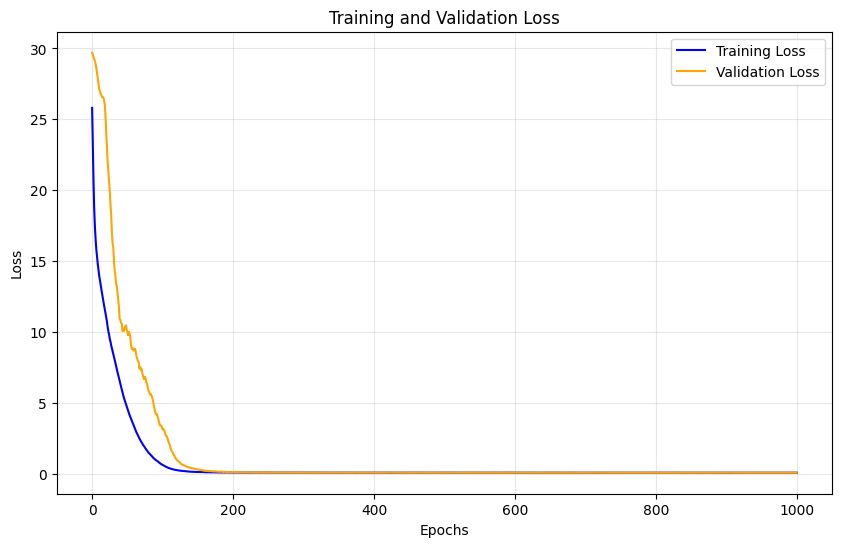

In [4]:
plot_loss(history)

# Prediction & Performance

In [3]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [4]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/scaled_o3/input4/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019_3input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*4], ctrl_data[:, 17*4]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 Nitrate
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2025-02-05 09:34:48.549921: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22337 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-02-05 09:34:48.551507: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22337 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-02-05 09:34:48.553064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22337 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-02-05 09:34:48.554513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21934 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

2/2 [==============================] - 2s 304ms/step


In [5]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [6]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [7]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


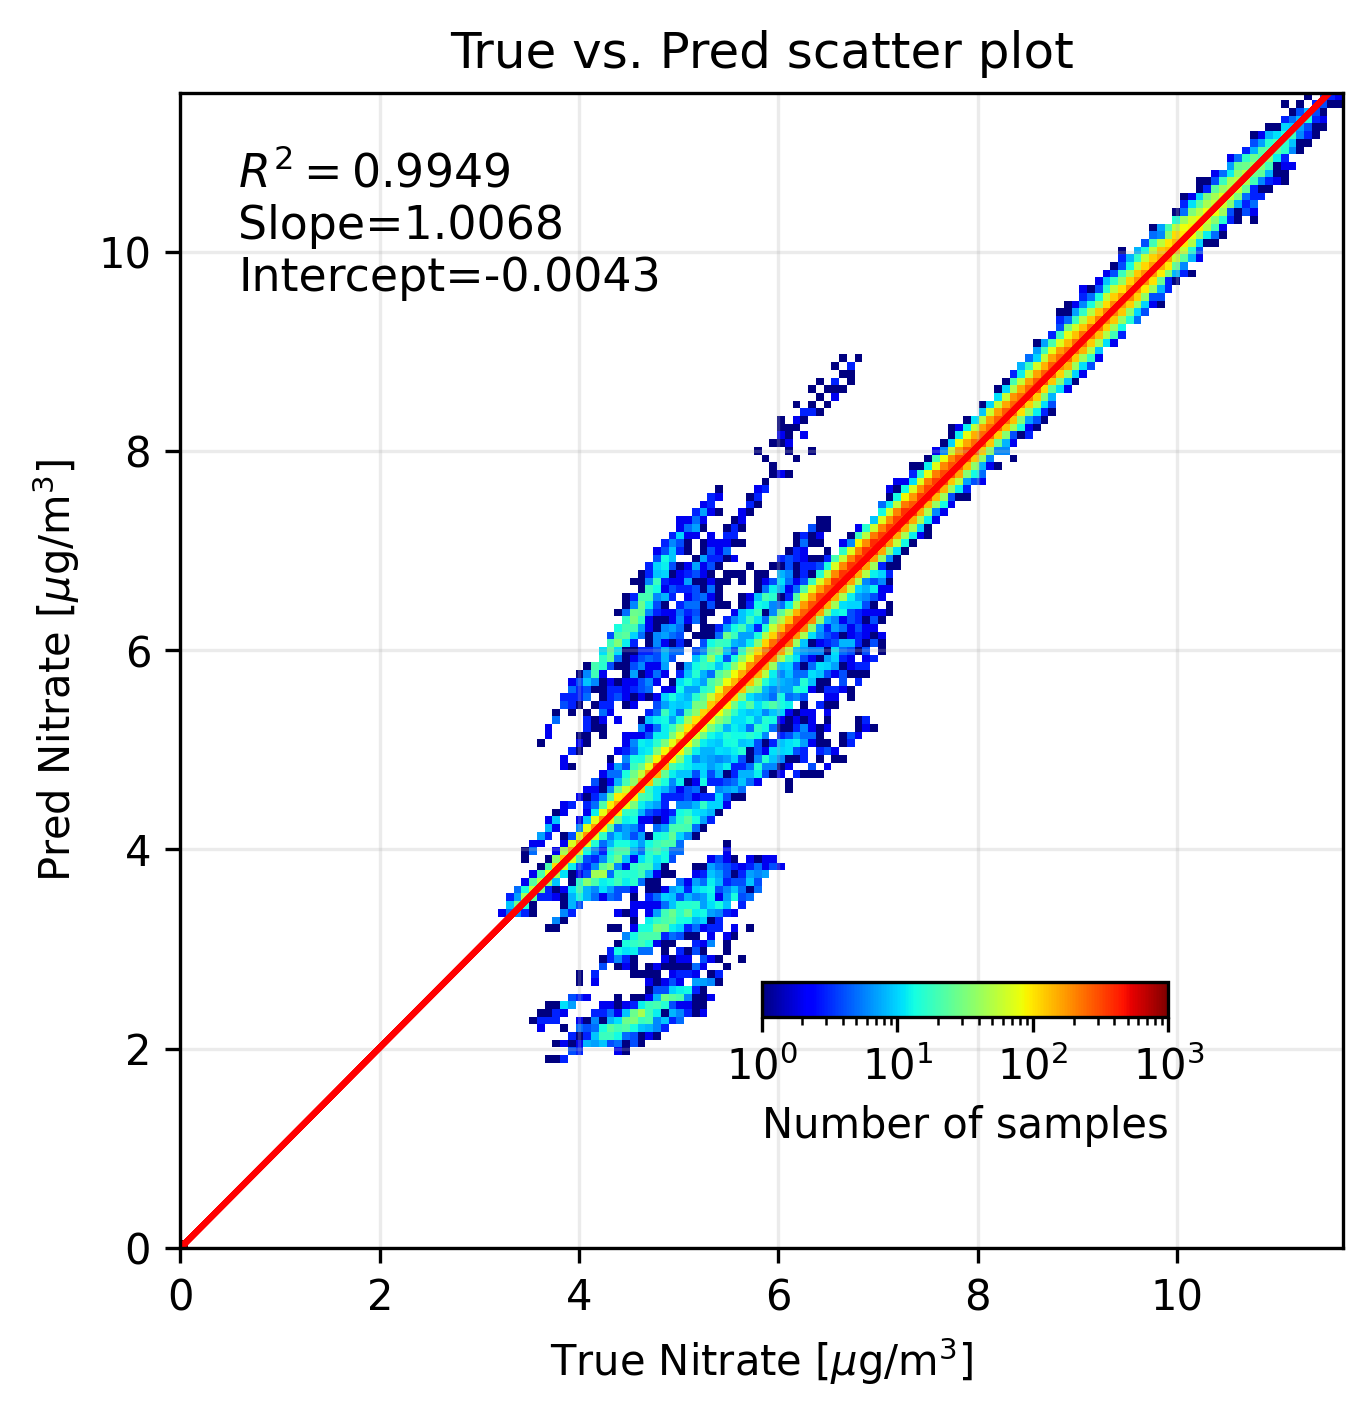

In [8]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

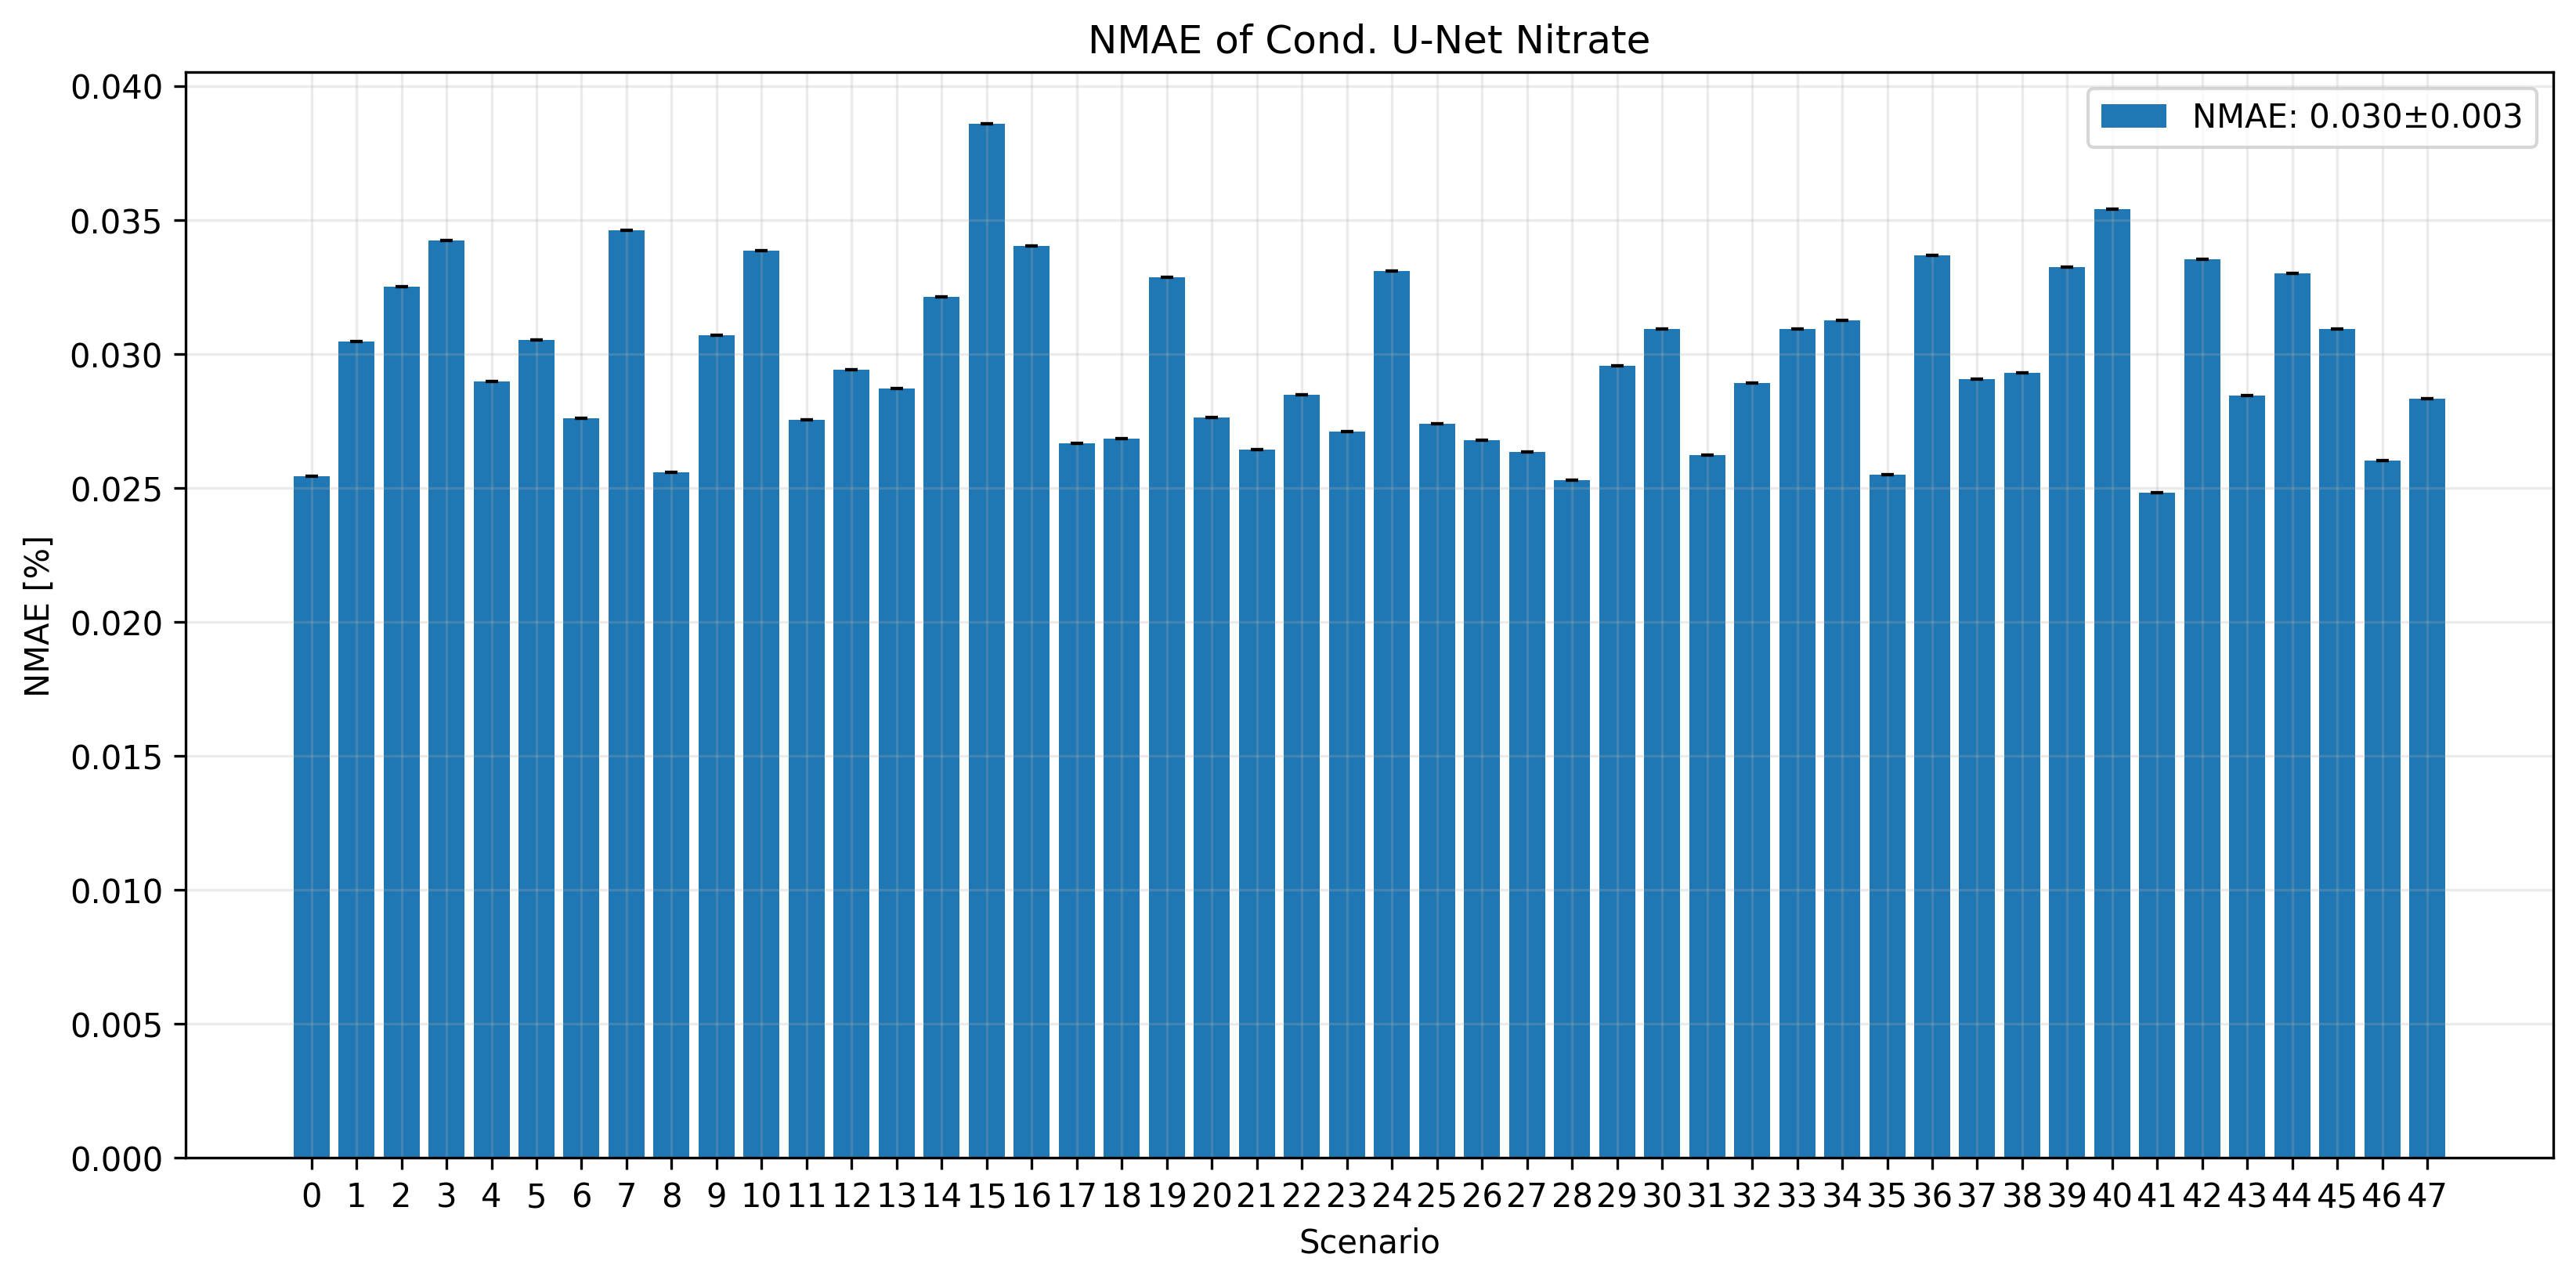

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

In [12]:
# np.set_printoptions(threshold=sys.maxsize)
# print(true_conc_map_w_lines[17])

[17]


/tmp/ipykernel_1462083/1207372777.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462083/1207372777.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])


/tmp/ipykernel_1462083/1207372777.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462083/1207372777.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462083/1207372777.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462083/1207372777.py:68: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])


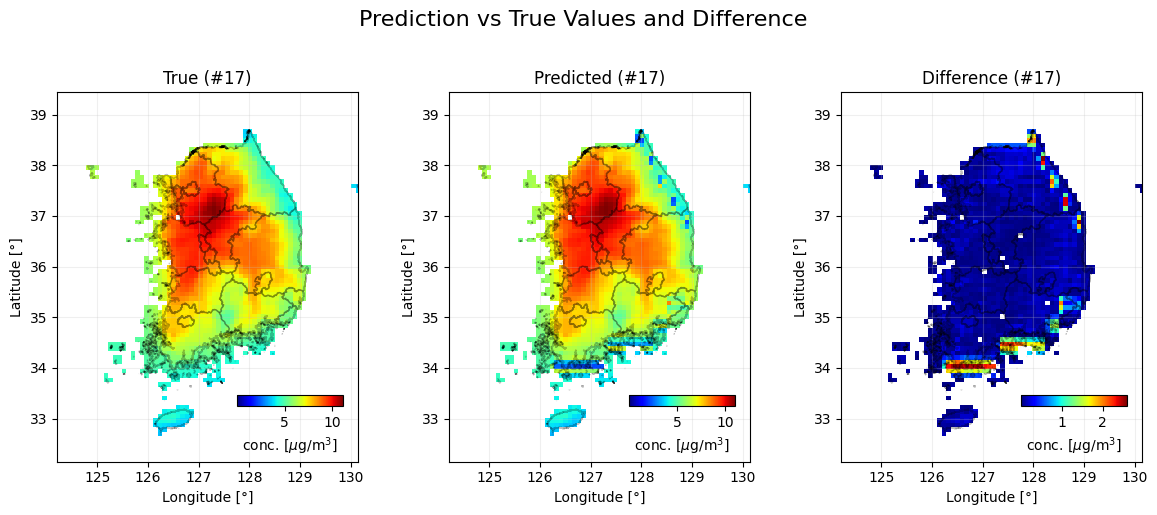

In [13]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=17)

In [14]:
true_conc_map_w_lines_re = true_conc_map_w_lines
pred_conc_map_w_lines_re = pred_conc_map_w_lines

true_conc_map_w_lines_re = np.delete(true_conc_map_w_lines, 17, axis=0)
pred_conc_map_w_lines_re = np.delete(pred_conc_map_w_lines, 17, axis=0)

print(true_conc_map_w_lines_re.shape)
print(pred_conc_map_w_lines_re.shape)

(47, 82, 67)
(47, 82, 67)


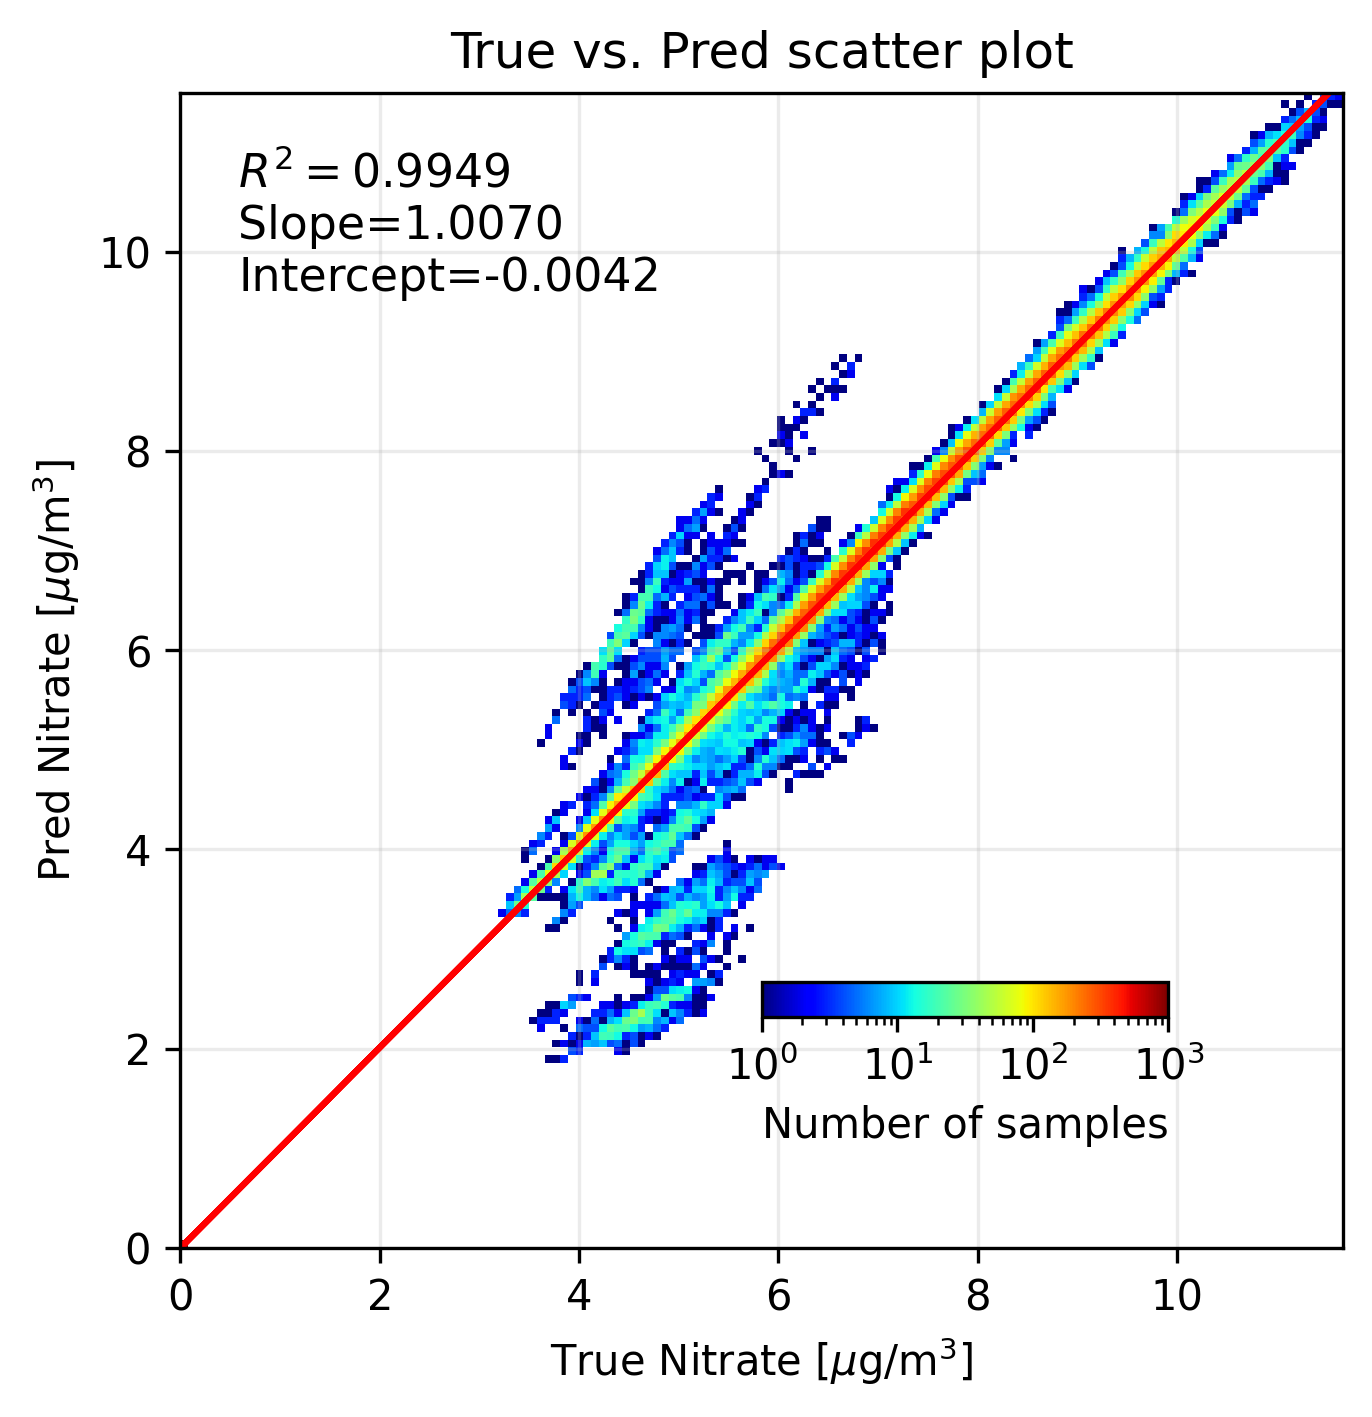

In [15]:
y_true_modi = true_conc_map_w_lines_re.reshape(-1)
y_pred_modi = pred_conc_map_w_lines_re.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

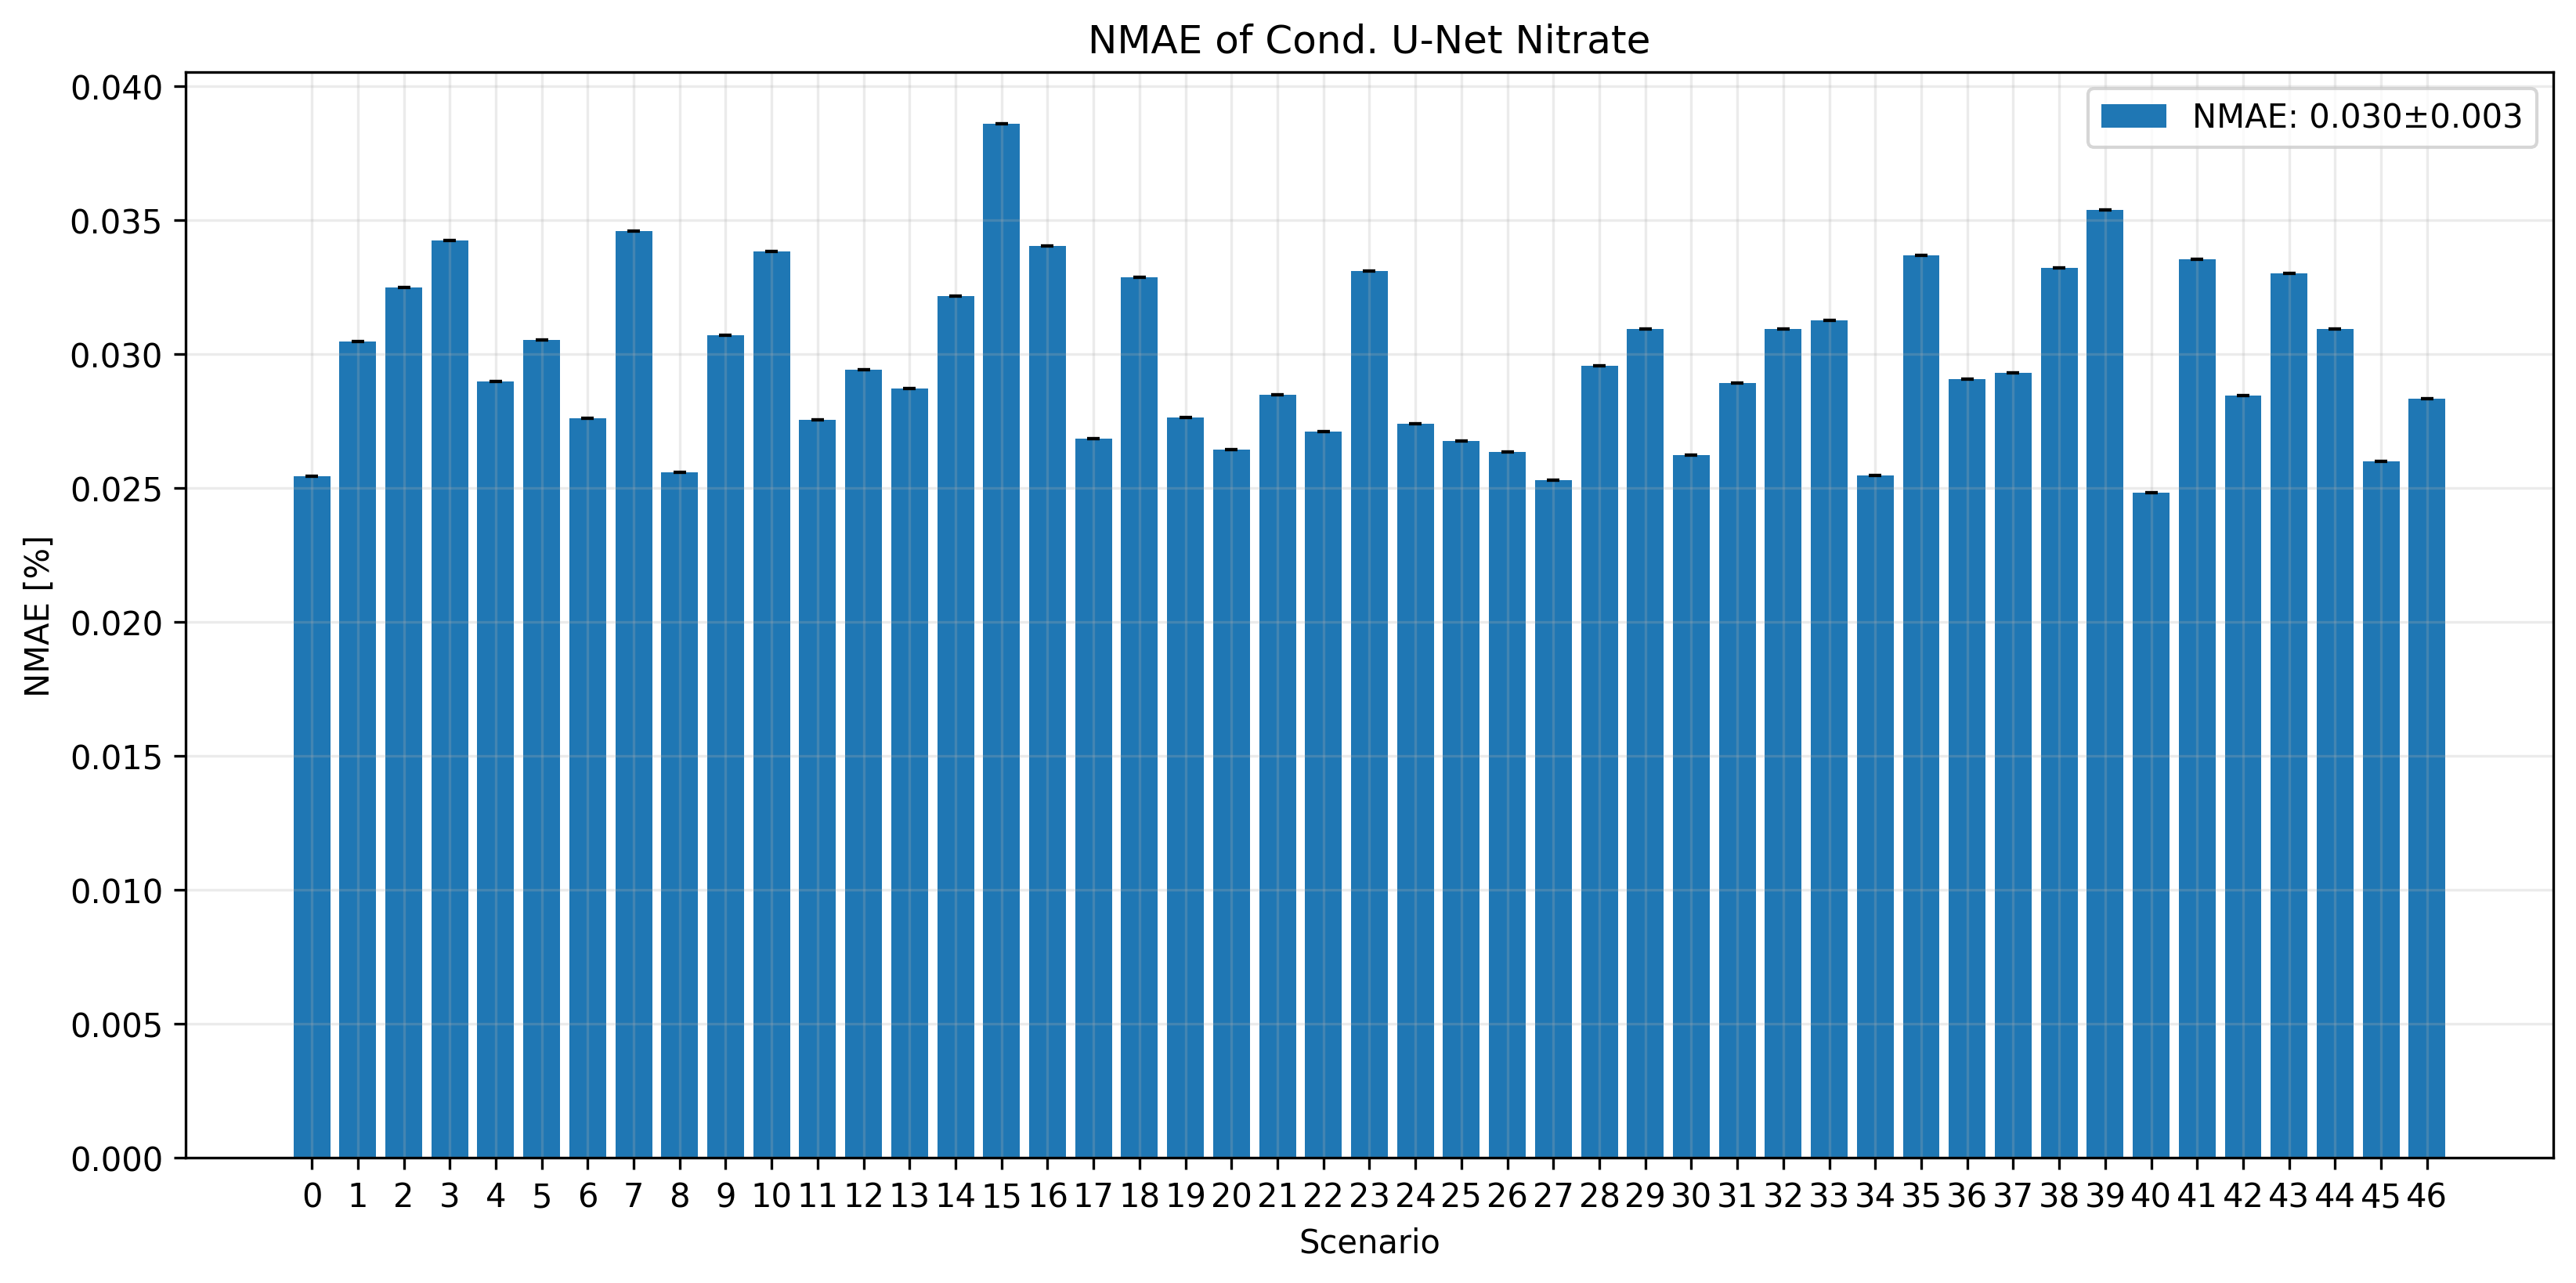

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines_re, pred_conc_map_w_lines_re)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]-1), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]-1), range(y_test.shape[0]-1))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()